In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\ProgramData\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start
    self.io_loop.start()
  File "c:\ProgramData\anaconda3\Lib\site-packa

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
!unzip -qq ./chip_data.zip -d data

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
dataset_path = "dataset"
train_dataset=datasets.ImageFolder(root=f"{dataset_path}/train",transform=transform)
test_dataset=datasets.ImageFolder(root=f"{dataset_path}/test",transform=transform)

In [ ]:
# Display some input images
def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert tensor format (C, H, W) to (H, W, C)
        axes[i].imshow(image)
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

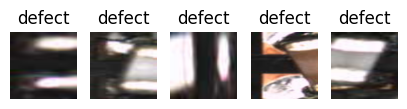

In [ ]:
# Show sample images from the training dataset
show_sample_images(train_dataset)

In [ ]:
# Get the total number of samples in the training dataset
print(f"Total number of training samples: {len(train_dataset)}")

# Get the shape of the first image in the dataset
first_image, label = train_dataset[0]
print(f"Shape of the first image: {first_image.shape}")

Total number of training samples: 172
Shape of the first image: torch.Size([3, 224, 224])


In [ ]:
print(f"Total testing samples: {len(test_dataset)}")
print(f"Shape of first test image: {test_dataset[0][0].shape}")

Total testing samples: 121
Shape of first test image: torch.Size([3, 224, 224])


In [ ]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:

model = models.vgg19(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final classifier layer
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Now unfreeze classifier parameters only
for param in model.classifier.parameters():
    param.requires_grad = True


C:\Users\admin\anaconda3\envs\deep_learning\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\anaconda3\envs\deep_learning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from torchsummary import summary
# Print model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Freeze all layers except the final layer
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extractor layers

In [ ]:
# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

In [ ]:
## Step 3: Train the Model
def train_model(model, train_loader,test_loader,num_epochs=10):
    train_losses = []
    val_losses = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Compute validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))
        model.train()

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Plot training and validation loss
    print("Name: Divyashree V")
    print("Register Number:212223230051")
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


Epoch [1/5], Train Loss: 0.5447, Validation Loss: 0.2804
Epoch [2/5], Train Loss: 0.2082, Validation Loss: 0.1647
Epoch [3/5], Train Loss: 0.0878, Validation Loss: 0.1344
Epoch [4/5], Train Loss: 0.0233, Validation Loss: 0.0935
Epoch [5/5], Train Loss: 0.0123, Validation Loss: 0.0835
Name:Gurumurthy S
Register Number:212223230066


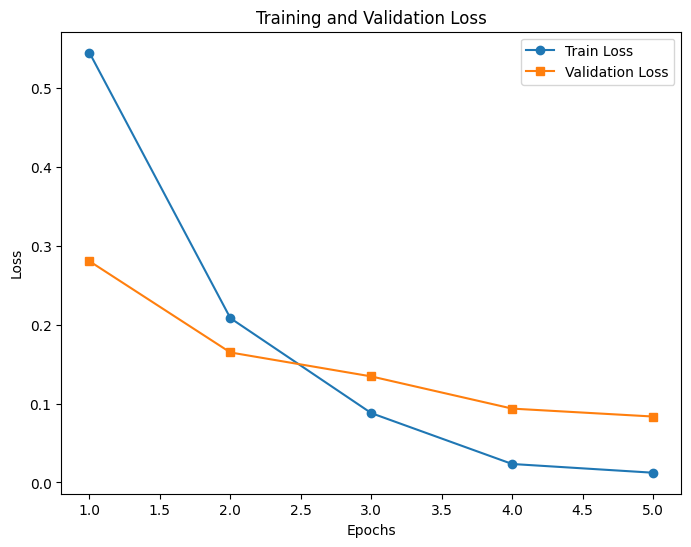

In [ ]:
train_model(model, train_loader, test_loader, num_epochs=5)

Test Accuracy: 0.9504
Name:Gurumurthy S
Register Number:212223230066


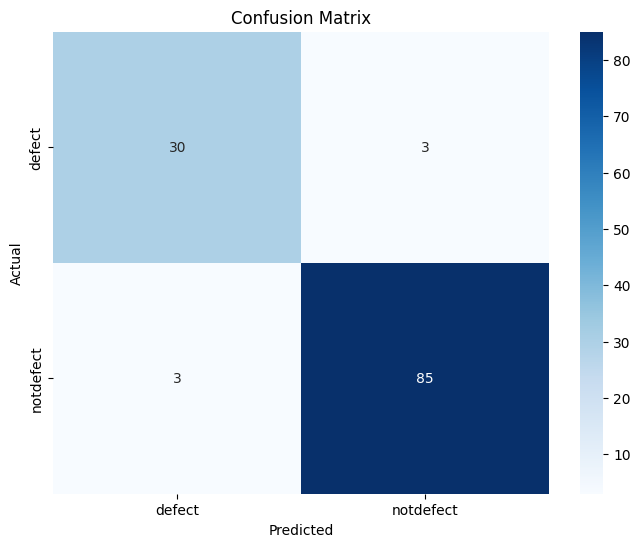

Classification Report:
              precision    recall  f1-score   support

      defect       0.91      0.91      0.91        33
   notdefect       0.97      0.97      0.97        88

    accuracy                           0.95       121
   macro avg       0.94      0.94      0.94       121
weighted avg       0.95      0.95      0.95       121



In [ ]:
## Step 4: Test the Model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    
    cm = confusion_matrix(all_labels, all_preds)
    print("Name:Gurumurthy S")
    print("Register Number:212223230066")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=train_dataset.classes, 
                yticklabels=train_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Evaluate
test_model(model, test_loader)

In [ ]:
## Step 5: Predict on a single image
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    image_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    class_names = dataset.classes
    image_to_display = transforms.ToPILImage()(image)
    plt.imshow(image_to_display)
    plt.title(f"Actual: {class_names[label]}\nPredicted: {class_names[predicted.item()]}")
    plt.axis('off')
    plt.show()

    print(f"Actual: {class_names[label]}, Predicted: {class_names[predicted.item()]}")


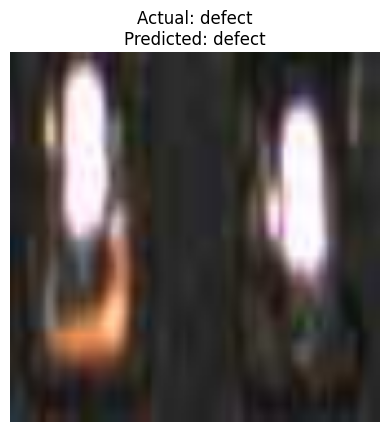

Actual: defect, Predicted: defect


In [ ]:
#Example Prediction
predict_image(model, image_index=25, dataset=test_dataset)